In [15]:
library(pcalg)
library(relaimpo)
library(igraph)

In [60]:
graph_plot3 <- function(table, 
                        name="DAG", 
                        vertex_label_size=1,  # Vertex label size
                        arrow_size=1,  # Arrow size for directed edges
                        edge_label_size = 2,  # Edge label size
                        label_round = 3  # Decimals to round for label
                       ) {
  
  nodes <- colnames(table)
  
  # Create edge list from matrix
  edge_list <- which(table != 0, arr.ind = TRUE)
  
  # Build a data frame for edges (source, target, weight)
  edges <- data.frame(
    from = nodes[edge_list[, 2]],  # Column is the source (j)
    to = nodes[edge_list[, 1]],    # Row is the target (i)
    weight = table[edge_list]
  )
  
  # Create igraph object
  g <- graph_from_data_frame(edges, directed = TRUE, vertices = nodes)
  
  # Set vertex attributes
  V(g)$size <- 15
  V(g)$label.cex <- vertex_label_size  # Customizable label size
  V(g)$label.color <- "black"
  V(g)$frame.color <- NA
  
  # Set edge attributes
  E(g)$width <- (E(g)$weight / max(E(g)$weight)) * 5  # Scale edge width
  E(g)$color <- "gray50"
  E(g)$arrow.size <- arrow_size  # Customizable arrow size
  
  # Display edge weights as labels
  E(g)$label <- round(E(g)$weight, label_round)  # Round to 2 decimal places
  E(g)$label.cex <- edge_label_size  # Larger edge label size
  E(g)$label.color <- "blue"  # Edge label color
  
  # Apply curvature parameter
  E(g)$curved <- 0 
  
  # Use a force-directed layout
  set.seed(123)
  layout_pos <- layout_with_fr(g)
  
  # Plot the graph
  plot(
    g,
    layout = layout_pos,
    vertex.label = V(g)$name,
    vertex.label.family = "Helvetica",
    edge.curved = FALSE,  # Disable curvature globally (individual edges still use E(g)$curved)
    edge.label = E(g)$label,  # Show edge weights
    edge.label.cex = E(g)$label.cex,  # Larger edge label size
    edge.label.color = E(g)$label.color,  # Edge label color
    main = name
  )
}


,X1,X2,X3,X4,X5
X1,0.0000000,0.00000000,0.0000000,0.0000000,0
X2,0.0000000,0.00000000,0.0000000,0.0000000,0
X3,0.7977388,0.00000000,0.0000000,0.0000000,0
X4,0.6601998,0.16733106,0.0000000,0.0000000,0
X5,0.2757287,0.03642359,0.3192793,0.3176964,0


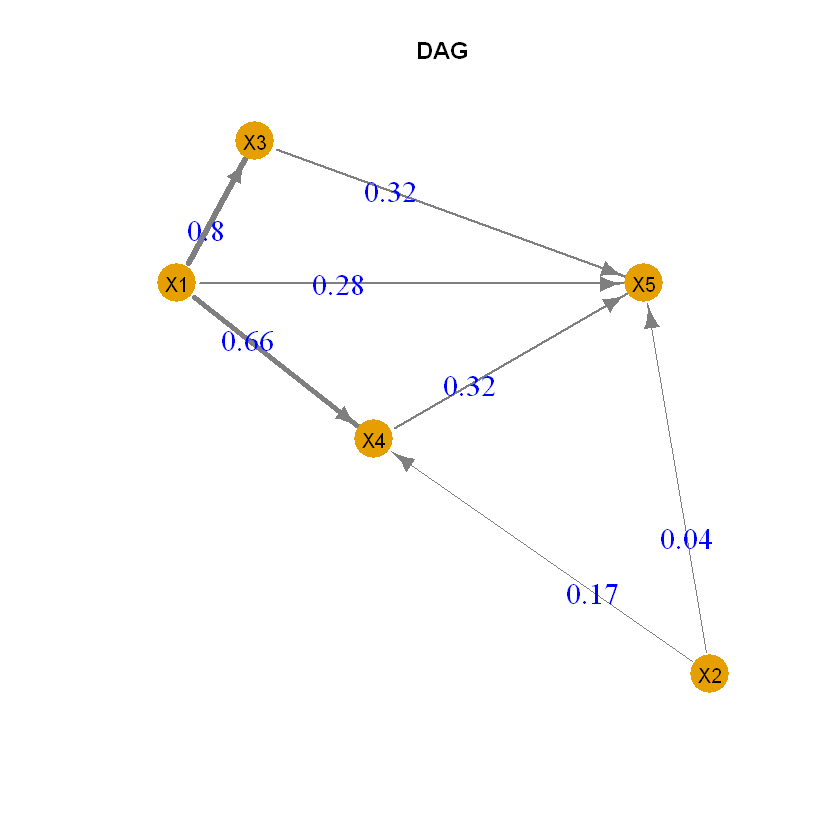

In [65]:
generate_sample <- function(n = 50, df=20) {
  X1 <- rt(n, df)
  X2 <- rt(n, df)
  X3 <- 2 * X1 + rt(n, df)
  X4 <- 2 * X1 + X2 + rt(n, df)  
  X5 <- X3 + X4 + rt(n, df)
    
  data <- data.frame(X1, X2, X3, X4, X5)
  return(data)
}

# Függvény meghívása
sample_data <- generate_sample(10000, 20)

spillover <- R2_dag(sample_data, "genizi")
spillover
graph_plot3(spillover, name="DAG", vertex_label_size=1, arrow_size=1, edge_label_size=1.5 , label_round=2)

In [57]:
compute_reachability <- function(amat) {
  # Ensure adjacency matrix is logical (TRUE/FALSE)
  reachability <- amat > 0
  
  n <- nrow(amat)
  node_names <- colnames(amat)
  
  # Compute transitive closure using matrix multiplication for efficiency
  for (k in seq_len(n)) {
    reachability <- reachability | (reachability %*% reachability > 0)
  }
  
  # Convert reachability matrix into a dictionary with column names
  reach_dict <- setNames(vector("list", n), node_names)
  
  for (i in seq_len(n)) {
    reachable_nodes <- which(reachability[, i])  # Get indices of reachable nodes
    reach_dict[[node_names[i]]] <- node_names[reachable_nodes]  # Map indices to column names
  }
  
  return(reach_dict)
}

R2_dag <- function(data, method) {
  # Learn the Bayesian network structure using LiNGAM
  model <- lingam(data, verbose=FALSE) 
  # Extract adjacency matrix
  coefs <- t(as.matrix(model$Bpruned))
  # Convert to binary adjacency matrix  
  amat <- ifelse(coefs != 0, 1, 0)
  
  # Assign column names to adjacency matrix
  colnames(amat) <- rownames(amat) <- colnames(data)
  
  # Get the number of variables
  p <- ncol(data)
  
  # Initialize result matrix
  result_matrix <- matrix(0, nrow = p, ncol = p)
  colnames(result_matrix) <- rownames(result_matrix) <- colnames(data)
  
  # Compute reachability paths
  paths <- compute_reachability(amat)
  
  # Iterate through nodes
  for (i in seq_len(p)) {
    # Identify parent nodes (nodes with paths leading to i)
    selected_cols <- paths[[colnames(data)[i]]]
    
    # Ensure at least one predictor exists
    if (length(selected_cols) > 0) {
      selected_cols <- c(colnames(data)[i], selected_cols)  # Add target variable
      
      # Subset data for regression
      filtered_data <- data[, selected_cols, drop = FALSE]
      
      # Fit linear model: target variable as dependent, others as independent
      model <- lm(filtered_data[, 1] ~ ., data = filtered_data[, -1, drop = FALSE])
      
      # Compute R-squared value
      r2 <- summary(model)$r.squared
      
      # If only one predictor, assign R² directly
      if (length(selected_cols) == 2) {  
        result_matrix[i, selected_cols[2]] <- r2
      } else {
        # Compute relative importance only if multiple predictors exist
        rel_importance <- calc.relimp(model, type = method, rela = TRUE) 
        
        # Extract slot values dynamically
        slot_values <- slot(rel_importance, tolower(method)) * r2
        
        # Store values in result matrix
        valid_cols <- intersect(names(slot_values), colnames(result_matrix))
        result_matrix[i, valid_cols] <- slot_values[valid_cols]
      }
    }
  }
  
  return(result_matrix)
}
